In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
from tensorflow.keras.layers import LayerNormalization, Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


# Dataset

In [ ]:
drive.mount('/content/drive')
# Path ke direktori dataset
data_dir = '/content/drive/My Drive/Capstone/Data/'

# Membuat DataFrame dari struktur direktori
categories = ['NORMAL', 'COVID', 'PNEUMONIA', 'TBC', 'CANCER', 'FIBROSIS', 'PLEURAL THICKENING']
data = []

for category in categories:
    folder_path = os.path.join(data_dir, category)
    for img in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img)
        data.append((img_path, category))

df = pd.DataFrame(data, columns=['image_path', 'category'])

Mounted at /content/drive


# Contoh Gambar X-ray dari dataset

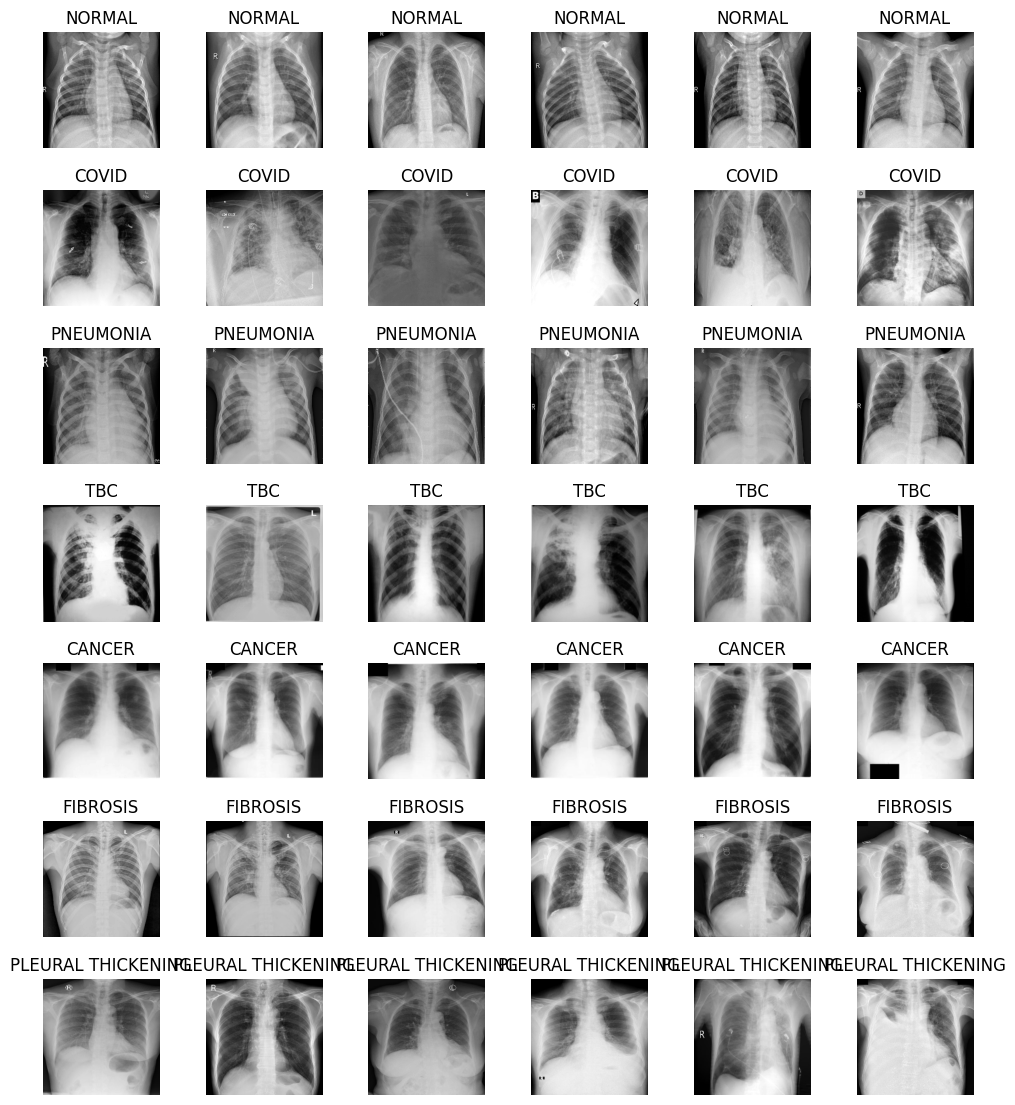

In [ ]:
# Fungsi untuk menampilkan contoh gambar dari setiap kategori
def display_samples(df, categories, target_size=(128, 128), num_samples=6):
    plt.figure(figsize=(num_samples * 2, len(categories) * 2))
    plt.subplots_adjust(wspace=0.4)  # Menentukan jarak horizontal antara subplot
    for i, category in enumerate(categories):
        sample = df[df['category'] == category].sample(num_samples)
        for j, row in enumerate(sample.iterrows()):
            plt.subplot(len(categories), num_samples, i * num_samples + j + 1)
            img_path, _ = row[1]
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, target_size)
            plt.imshow(img, cmap='gray')
            plt.title(category)
            plt.axis('off')
    plt.show()

# Display contoh gambar
display_samples(df, categories, target_size=(224, 224))

# Splitting Dataset


In [ ]:
# Bagi data menjadi train, validation, dan test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

# Inisialisasi generator gambar untuk setiap set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Definisikan batch size
batch_size = 32

# Buat generator gambar untuk setiap set
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='category',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='category',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='category',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 6645 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 3 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


Found 830 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


Found 831 validated image filenames belonging to 7 classes.


# Modelling

In [ ]:
# Load pre-trained ResNet50 model tanpa lapisan output
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Bekukan semua lapisan dari base model
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Tambahkan lapisan kustom di atas base model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = LayerNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(categories), activation='softmax')(x)

# Gabungkan base model dengan lapisan kustom dan metadata input
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Tampilkan ringkasan model
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Running The Model

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto', baseline=None, restore_best_weights=False)

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/30
208/208 [==============================] - 3147s 15s/step - loss: 1.1514 - accuracy: 0.5974 - val_loss: 0.4222 - val_accuracy: 0.8518 - lr: 1.0000e-04
Epoch 2/30
208/208 [==============================] - 207s 996ms/step - loss: 0.6698 - accuracy: 0.7783 - val_loss: 0.3785 - val_accuracy: 0.8747 - lr: 1.0000e-04
Epoch 3/30
208/208 [==============================] - 203s 977ms/step - loss: 0.5464 - accuracy: 0.8318 - val_loss: 0.3621 - val_accuracy: 0.8663 - lr: 1.0000e-04
Epoch 4/30
208/208 [==============================] - 203s 971ms/step - loss: 0.5082 - accuracy: 0.8364 - val_loss: 0.4023 - val_accuracy: 0.8470 - lr: 1.0000e-04
Epoch 5/30
208/208 [==============================] - 203s 973ms/step - loss: 0.4521 - accuracy: 0.8504 - val_loss: 0.3330 - val_accuracy: 0.8892 - lr: 1.0000e-04
Epoch 6/30
208/208 [==============================] - 208s 1000ms/step - loss: 0.3994 - accuracy: 0.8704 - val_loss: 0.2334 - val_accuracy: 0.9205 - lr: 1.0000e-04
Epoch 7/30
208/208 [==

# Save The Model

In [ ]:
# Path di Google Drive
model_save_path = '/content/drive/My Drive/Capstone/model_vgg16(2).h5'

# Simpan model
model.save(model_save_path)
print(f'Model saved to {model_save_path}')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/drive/My Drive/Capstone/model_vgg16(2).h5


# Plotting Loss and Accuracy

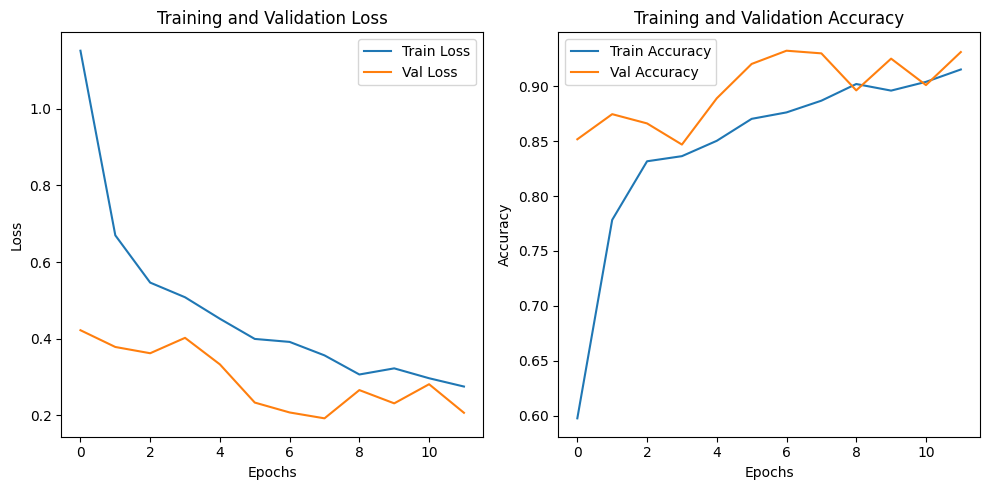

In [ ]:
# Plot Loss
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluating the Model

In [ ]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder on true_labels
label_encoder.fit(true_labels)

# Transform true_labels to numerical labels
true_labels_encoded = label_encoder.transform(true_labels)

# Note: The label_encoder.classes_ attribute contains the original labels and their corresponding numerical values
# You may need this information later for interpretation or visualization of results.
from sklearn.metrics import confusion_matrix

predictions = np.argmax(predictions, axis=1)
# Calculate confusion matrix
cm = confusion_matrix(true_labels_encoded, predictions)

# Print or visualize the confusion matrix
print('Confusion Matrix:')
print(cm)


Confusion Matrix:
[[ 12   0   0   0   0   0   0]
 [  2  43   0   0   4   0   0]
 [  0   0   8   0   1   0   0]
 [  0   0   0 171   0   2   0]
 [  1   0   0   0  95   0   0]
 [  0   0   0  37   0 394   0]
 [  1   0   0   0   1   0  59]]


In [ ]:
from sklearn.metrics import classification_report

# Membuat prediksi pada data validasi
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Memperoleh label sebenarnya dari data validasi
true_labels = test_generator.classes

# Menghitung presisi, recall, dan F1-score
report = classification_report(true_labels, predicted_labels)

# Menampilkan laporan klasifikasi
print(report)


26/26 [==============================] - 12s 438ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      0.92      0.96        49
           2       0.89      0.89      0.89         9
           3       0.82      0.99      0.90       173
           4       0.94      1.00      0.97        96
           5       0.99      0.91      0.95       431
           6       1.00      0.97      0.98        61

    accuracy                           0.94       831
   macro avg       0.95      0.95      0.95       831
weighted avg       0.95      0.94      0.95       831



In [ ]:
import tensorflow as tf

# Path to the input HDF5 (Keras) model
h5_model_path = '/content/drive/My Drive/Capstone/model_vgg16(2).h5'

# Path to save the converted TFLite model
tflite_model_path = '/content/drive/My Drive/Capstone/tflite_model_vgg16(2).tflite'

# Load the Keras model
model = tf.keras.models.load_model(h5_model_path)

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)


In [ ]:
pip install tflite-support-nightly

In [ ]:
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils

# Path to your TensorFlow Lite model file
_MODEL_PATH = "/content/drive/My Drive/Capstone/tflite_model_vgg16(2).tflite"
# Path to output model file with metadata
_SAVE_TO_PATH = "/content/drive/My Drive/Capstone/modelvgg16_with_metadata.tflite"
# Path to your labels.txt file
_LABEL_FILE = "/content/drive/My Drive/Capstone/labels.txt"
# Normalization parameters if required
_INPUT_NORM_MEAN = 127.5
_INPUT_NORM_STD = 127.5

# Load model
model = tf.lite.Interpreter(model_path=_MODEL_PATH)
model.allocate_tensors()

# Create the metadata writer
writer = image_classifier.MetadataWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH),
    [_INPUT_NORM_MEAN],
    [_INPUT_NORM_STD],
    [_LABEL_FILE])

# Populate the metadata into the model
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

print(f"Metadata added to the model and saved to {_SAVE_TO_PATH}")


Metadata added to the model and saved to /content/drive/My Drive/Capstone/modelvgg16_with_metadata.tflite
